# Import Library


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.10.1
Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [4]:
# Creates datasets for training and validation.
def train_val_test_datasets(): 

# Define rescaling layer
    rescale = tf.keras.layers.Rescaling(1./255)

# Load train dataset
    train_ds, validation_ds  = tf.keras.utils.image_dataset_from_directory(
        directory='./datasetV2',
        batch_size=16,
        image_size=(224, 224),
        validation_split=0.2,
        subset="both",
        seed=123,
        label_mode='categorical',  # Assuming you have multiple classes
    )

# Preprocess train dataset (rescale)
    train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Preprocess validation dataset (rescale)
    validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

# Load test dataset
    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory='./datasetV2',  # Specify the directory for the test dataset
        batch_size=16,
        image_size=(224, 224),
        label_mode='categorical',  # Assuming you have multiple classes
        shuffle=False,
)

# Preprocess test dataset (rescale)
    test_ds = test_ds.map(lambda x, y: (rescale(x), y))
                          
    return train_ds, validation_ds, test_ds

In [5]:
train_ds, validation_ds, test_ds = train_val_test_datasets()

Found 8383 files belonging to 8 classes.
Using 6707 files for training.
Using 1676 files for validation.
Found 8383 files belonging to 8 classes.


In [6]:
# Check the first image shape in the training dataset
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
# Check the first image shape in the validation dataset
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
# Check the first image shape in the test dataset
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (224, 224, 3)
Shape of the first image in the validation dataset: (224, 224, 3)
Shape of the first image in the test dataset: (224, 224, 3)


In [7]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

# Iterate through the dataset
for images, _ in train_ds:
    # Compute the minimum and maximum pixel values in the current batch of images
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)
    
    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Print the minimum and maximum pixel values
print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())

Minimum pixel value: 0.0
Maximum pixel value: 1.0


# Visualization

In [8]:
def visualize_images(path, target_size=(224, 224), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Bitot_Spot_of_Vitamin_A_Deficiency

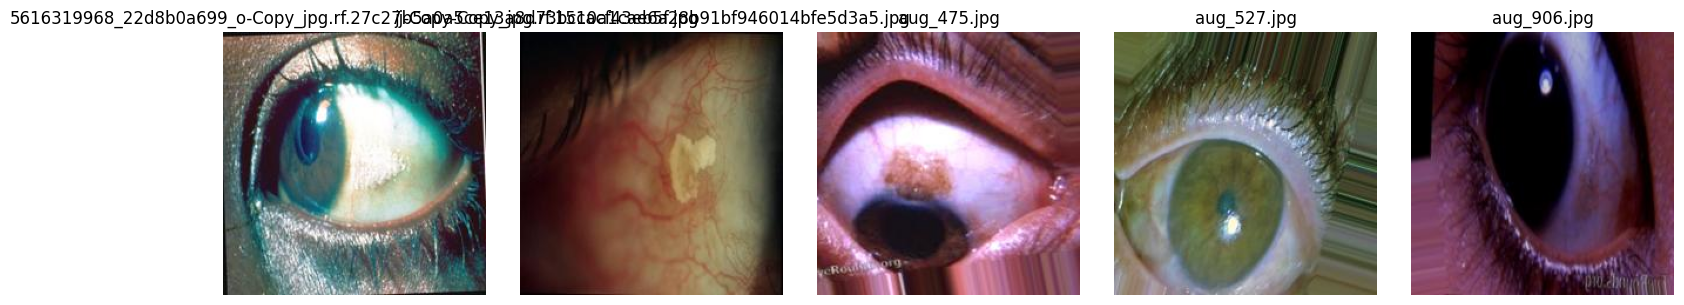

In [9]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Bitot_Spot_of_Vitamin_A_Deficiency"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Cataract

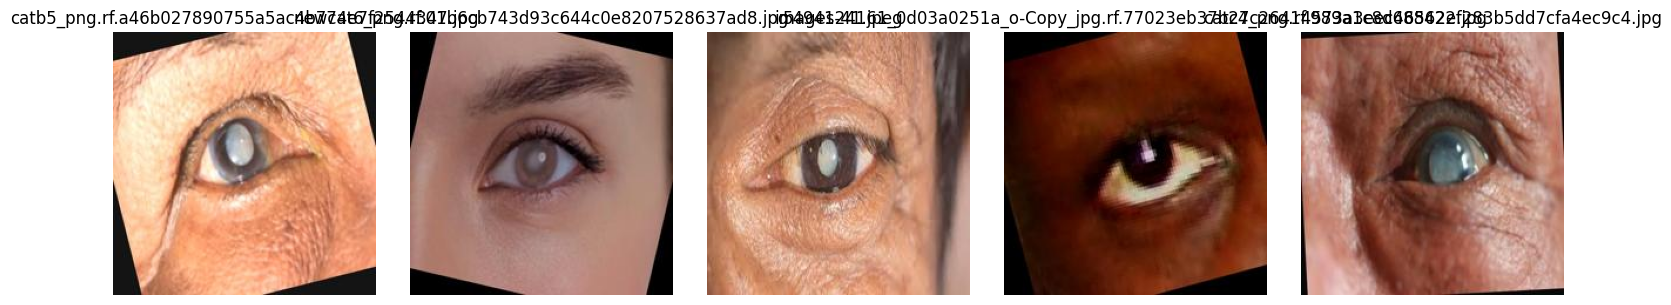

In [34]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Cataracts"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Cellulitis

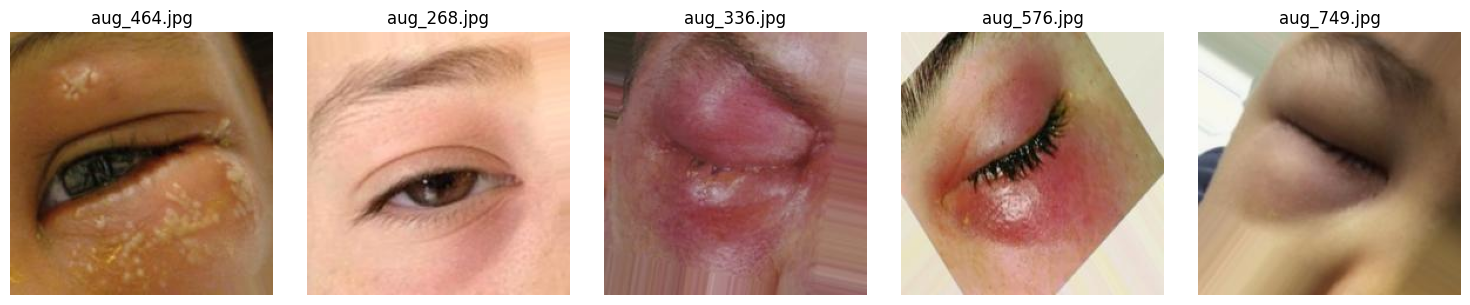

In [35]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Cellulitis eye"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Conjunctivitis

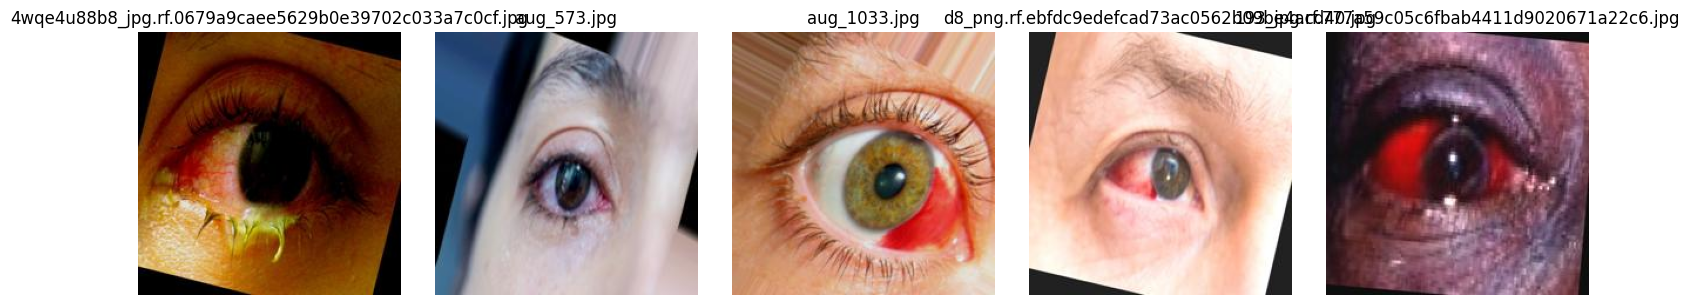

In [36]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Conjunctivitis"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Corneal ulcer

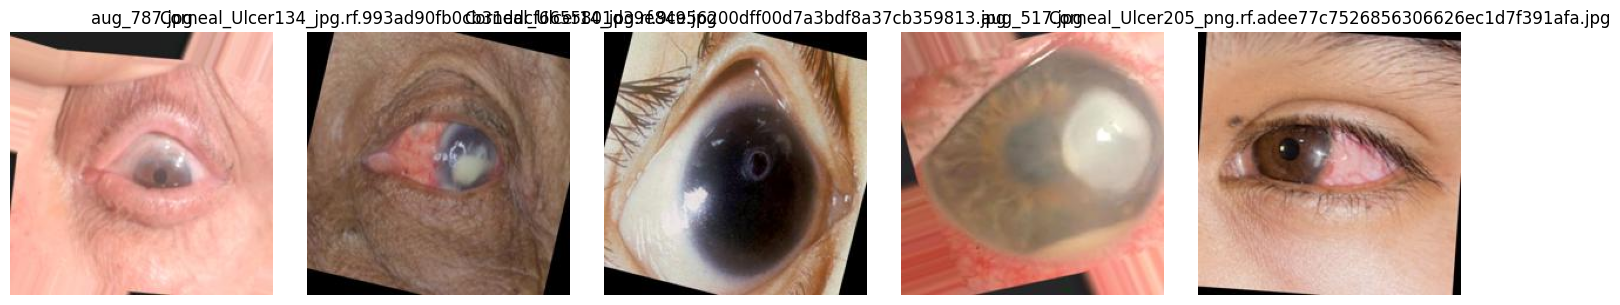

In [37]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Corneal_Ulcer"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Ectropion

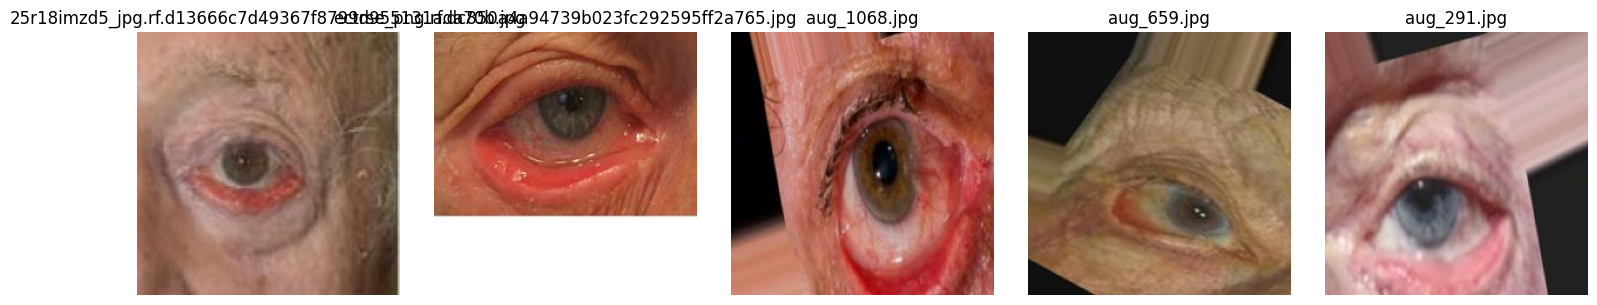

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Ectropion"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Glaucoma

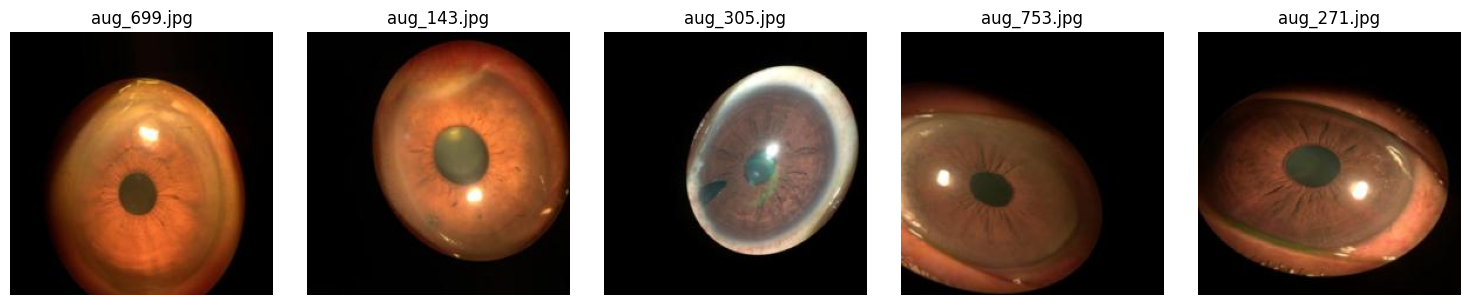

In [14]:
# Specify the path containing the images to visualize
path_to_visualize = "dataset/Glaucoma"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Normal

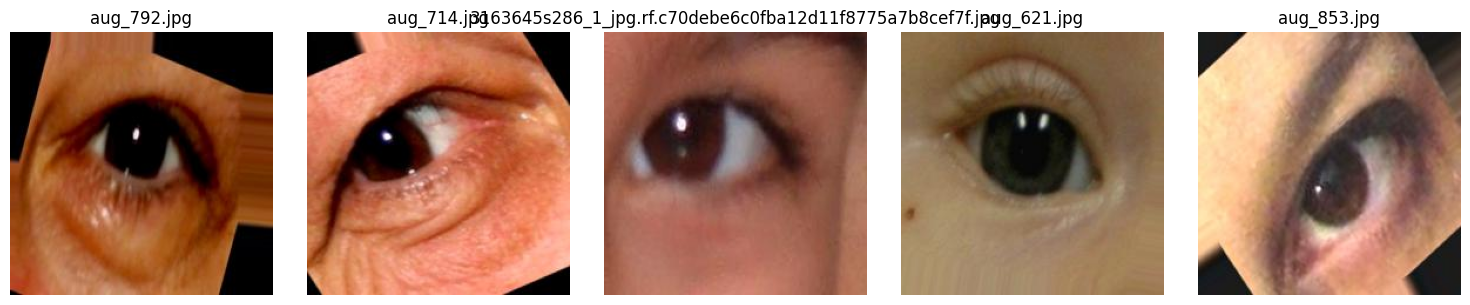

In [38]:
# Specify the path containing the images to visualize
path_to_visualize = "datasetV2/Normal_Eye"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# Model


In [10]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),  # First optional dense layer
    tf.keras.layers.Dropout(0.5),  # Dropout added here
    tf.keras.layers.Dense(256, activation='relu'),  # Second optional dense layer
    tf.keras.layers.Dense(8, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 256)      0

In [11]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
420/420 [==============================] - 60s 124ms/step - loss: 1.8495 - accuracy: 0.2670 - val_loss: 1.6903 - val_accuracy: 0.3866
Epoch 2/50
420/420 [==============================] - 50s 120ms/step - loss: 1.4881 - accuracy: 0.4485 - val_loss: 1.1745 - val_accuracy: 0.5728
Epoch 3/50
420/420 [==============================] - 54s 127ms/step - loss: 1.1722 - accuracy: 0.5725 - val_loss: 1.1051 - val_accuracy: 0.6146
Epoch 4/50
420/420 [==============================] - 55s 131ms/step - loss: 0.9660 - accuracy: 0.6541 - val_loss: 0.8237 - val_accuracy: 0.6957
Epoch 5/50
420/420 [==============================] - 58s 139ms/step - loss: 0.8128 - accuracy: 0.7078 - val_loss: 0.7553 - val_accuracy: 0.7232
Epoch 6/50
420/420 [==============================] - 58s 139ms/step - loss: 0.7011 - accuracy: 0.7464 - val_loss: 0.6281 - val_accuracy: 0.7816
Epoch 7/50
420/420 [==============================] - 58s 137ms/step - loss: 0.5945 - accuracy: 0.7831 - val_loss: 0.4997 - val_ac

# Evaluate

In [12]:
val_loss, val_accuracy = model.evaluate(validation_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

105/105 [==============================] - 6s 61ms/step - loss: 0.3113 - accuracy: 0.9069
Validation Loss: 0.3113173246383667
Validation Accuracy: 0.9069212675094604


In [13]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

524/524 [==============================] - 32s 62ms/step - loss: 0.0700 - accuracy: 0.9802
Test accuracy: 0.9801980257034302


## History

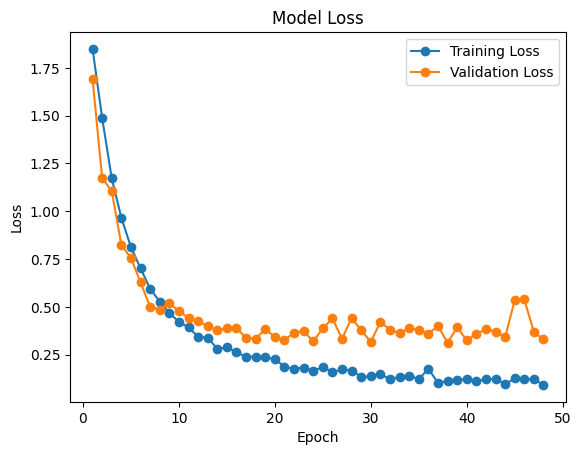

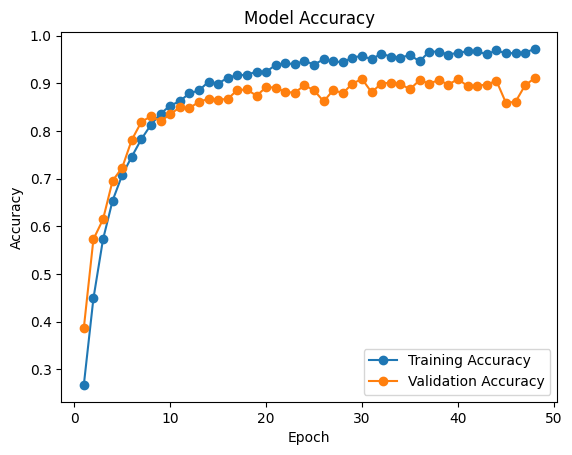

In [14]:
# Define epochs
epochs = range(1, len(history.history['loss']) + 1)

# Plot training & validation loss
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Convert one-hot encoded labels back to class indices
def decode_labels(dataset):
    y_true = []
    for _, labels in dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices
    return np.array(y_true)

# Collect predictions and true labels
y_true = decode_labels(test_ds)  # True labels from test dataset
y_pred = []  # Predicted labels

for images, _ in test_ds:
    predictions = model.predict(images)  # Predict class probabilities
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert to class indices

y_pred = np.array(y_pred)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


1/1 [==============================] - 0s 32ms/step
Confusion Matrix:
[[1032    0    1    1    3    1    4    5]
 [   4 1026    2    1    6    0    3    6]
 [   0    0 1036    3    0    0    0    9]
 [   2    0    5 1022    3    4    3    9]
 [   6    2    1   12 1000   12    9    6]
 [   1    0    3    5   10 1025    1    3]
 [   1    0    0    1    5    0 1039    2]
 [   4    0    3    1    0    2    1 1037]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1047
           1       1.00      0.98      0.99      1048
           2       0.99      0.99      0.99      1048
           3       0.98      0.98      0.98      1048
           4       0.97      0.95      0.96      1048
           5       0.98      0.98      0.98      1048
           6       0.98      0.99      0.99      1048
           7       0.96      0.99      0.98      1048

    accuracy                           0.98      8383
   macro avg       

In [17]:
model_name = 'Sight Safe'
subject = 'Eye Disease'
acc = test_accuracy * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as Sight Safe-Eye Disease-98.02.h5
weights were saved as Sight Safe-Eye Disease-weights.h5


In [18]:
# Save model structure in json file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save trained model weight in .h5 file
model.save_weights('eye_model.h5')